# Generate Vertically Nominated Prediction Paragraphs

In [1]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

### Generate parameters from vertically curated training data
- To define the "vertically curated training df" I only filtered out of the original csv:
    - rows with data_key_friendly_names that I did not deem "relevant dkfns." 
    - rows where the text value was not found in the paragraph_text
        -🤔 I can't remember if I did a literal text in paragraph_text or if I tokenized it first

In [2]:
#### read in the vertical training subset
vert_training_subset_df = pd.read_csv('data/vertical_training_subset.csv', index_col=[0])
vert_training_subset_df.head(2)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text
0,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ..."
1,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ..."


In [3]:
### these are the only dkfns that I'm currently working with
print(set(vert_training_subset_df.data_key_friendly_name))
relevant_dkfns = list(set(vert_training_subset_df.data_key_friendly_name))
relevant_dkfns

{'Share Repurchase Authorization', 'Share Repurchase Utilization', 'Unknown Share Repurchase Data', 'Share Repurchase Intention'}


['Share Repurchase Authorization',
 'Share Repurchase Utilization',
 'Unknown Share Repurchase Data',
 'Share Repurchase Intention']

In [4]:
### compile a string from the text column

text_list = [t.lower() for t in vert_training_subset_df.text]
text_string = ''
for t in text_list:
    text_string = text_string + t + ' '
    ### tokenize the text string

text_tokens = [w for w in word_tokenize(text_string) if w.isalpha()]
no_stops = [t for t in text_tokens if t not in stopwords.words('english')]
#print(no_stops[0:10])
### limit ourselves to the 15 most common tokens
    # although this can be modulated if necessary
key_tokens = pd.DataFrame(Counter(no_stops).most_common(15))
key_tokens.columns = ['key_tok', 'kt_count']

can probably improve the above list of key_tokens by using less than 30 terms.... maybe
#### 🤔 I could enhance my key_tokens by doing tf-idf
- between the text column and the the html text - the text column
    - which terms are prominent in text column that are not prominent in the rest of the html
    - which terms are prominent in the noisy signal that are not prominent in the noise?
- I could also enhance it by removing noisy words like 'total'

In [5]:
# read in the csv
share_rprchs_prgrph_df = pd.read_csv('data/share_repurchase_paragraphs.csv')

# Generate parameters from the csv
par_lengths = [len(par) for par in share_rprchs_prgrph_df.paragraph_text]
margin = int(np.std(par_lengths))

#### Initialize a predictions dataframe
- copy the index, ticker, and accession_number columns from the original csv

In [6]:
share_rprchs_prgrph_df.columns

Index(['ticker', 'accession_number', 'data_key_friendly_name', 'text',
       'data_value', 'reported_data_value', 'reported_units',
       'paragraph_text'],
      dtype='object')

In [7]:
predicted_paragraph_df = share_rprchs_prgrph_df[['ticker', 'accession_number']] # drop training data
predicted_paragraph_df.drop_duplicates(inplace = True) # reduce to unique rows
predicted_paragraph_df.reset_index(drop=True, inplace=True)
predicted_paragraph_df['pred_paragraph_text'] = ['nope' for row in predicted_paragraph_df.index]# initialize the pred_paragraph_text column
predicted_paragraph_df.head()

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ticker,accession_number,pred_paragraph_text
0,A,0001090872-17-000018,nope
1,AAL,0000006201-18-000009,nope
2,AAP,0001158449-18-000039,nope
3,AAPL,0000320193-17-000070,nope
4,ABBV,0001551152-18-000014,nope


In [8]:
predicted_paragraph_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 3 columns):
ticker                 435 non-null object
accession_number       435 non-null object
pred_paragraph_text    435 non-null object
dtypes: object(3)
memory usage: 10.3+ KB


In [9]:
predicted_paragraph_df.describe()

,ticker,accession_number,pred_paragraph_text
count,435,435,435
unique,434,435,1
top,STZ,0001091667-18-000025,nope
freq,2,1,435


#### Stage filings to be read in iteratively

In [10]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

## Run the "vertical" paragraph prediction routine on all the data in the training csv
- I call it a veritcal routine, because it uses the 'text' column to predict the 'paragraph_text' column. 
    - (contrast to "horizontal strategies" that use values from the top slice of dataframe rows to predict the bottom slice)

In [11]:
# initialize some score keeping lists
total_inclusion = []
inclusion_rates = [] # analogous to true positive rate
extra_baggage_rate = [] # analogous to false positive rate, (sorta, cause the actual paragraph data is not to be treated as an absolute standard).
actual_paratokens_lengths = []
nominated_paratokens_lengths = []
filings_not_in_df = [] # track which, if any, filings were not found in the df
no_tokhits_filings = [] # track which filings I failed to find hits for, if any

t0 = datetime.datetime.now()

for filing in training_filings_list:
#for filing in vert_training_subset_filings_list:
    ti = datetime.datetime.now()
    #print('processing next filing at ', ti)
    
    
### this could be all be packed into a function if nec.
###
    # read in the filing's html
    with open(filing) as file:
        file_html = file.read()
    
    # parse the html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ##################------- Predict Paragraphs ------##############################################
    #define candidate paragraphs by clustering of overlapping token-hit-margins
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraphs and a hit tracker
    candidate_paragraphs = []
    hit = 0
    #
    # work through the hits until I exhaust the list
    while hit < len(flater_list_of_tokhits) - 1:
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
    #     
    #    # loop from the hit + 1 (cause we used the former hit to initialize the bounds)
        for i in range(hit + 1, len(flater_list_of_tokhits)):
    #        # if the next token's start is within the current paragraph's bounds and it isnt the last hit
            if (leftbound < flater_list_of_tokhits[i][1] < rightbound) and (i != len(flater_list_of_tokhits) - 1):
    #            # expand the right bound with respect to next token's end
                rightbound = flater_list_of_tokhits[i][2] + margin
    #             
    #        # if next token is outside the bounds of current paragraph or we are at the penultimate hit
            else:
    #            # if right bound is out of htmls range, then adjust it to the end of the html
                if rightbound > len(string_filing):
                    rightbound = len(string_filing)
    #            # define current paragraph
                par = string_filing[leftbound:rightbound] ########### (if the code needs to be made more efficient I could store the paragraph start and end indices instead of storing the strings)
    #            # store the paragraph in a list of candidates
                candidate_paragraphs.append(par)
    #            # note which hit we need to start on for the next iteration of the while loop
                hit = i
    #            # now that we've found the outer bounds of the current paragraph we can interrupt the for loop
                break #this only interrupts the nearest parent loop 
    # this is just a repetition of the above routine to handle the last hit. There is probably a better way to handle this but we can enhance that later
    if hit == len(flater_list_of_tokhits)-1:
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
        if rightbound > len(string_filing):
            rightbound = len(string_filing)
        par = string_filing[leftbound:rightbound]
        candidate_paragraphs.append(par)
    #--------------------------------------------------------------------------------------#
    
    #################--------- Validate Predictions ----------------------##################
    # Future Enhancements:
    # - I could make the loop "reactive" so that if the validation score of the first
    #      nominated paragraph is low it con test the validation score of the second 
    #      nominee
    #
    # --------------- temporarily store the candidate paragraphs in a df ------------------
    candidate_df = pd.DataFrame(candidate_paragraphs)
    candidate_df.columns = ['cand_par']
    candidate_df['len'] = [len(par) for par in candidate_df.cand_par]
    # --------------- rank the candidate paragraphs by basic length (longer paragraphs correspond to denser clusters)
    candidate_df.sort_values(by = 'len', ascending = False, inplace = True)
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- filter candidates down to those with 'repurchase' in them
    candidate_df = candidate_df[['repurchase' in par for par in candidate_df.cand_par]]
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- nominee(s) will be the top 1 - 3 in the filterd df
    if len(candidate_df.cand_par) != 0:
        nominated = candidate_df.cand_par[0]
    elif len(candidate_df.cand_par) == 0:
        # if I failed define a single candidate paragraph
        print('failed to define a single candidate paragraph for filing', filing)
        print('defaulted to using the nominated paragraph from the last filing')
        no_tokhits_filings.append(filing)
    # clean up the nominee for validation
    nom_validatable = re.sub(r'\n+', ' ', nominated) # remove new lines
    nom_validatable = re.sub(r'\s+', ' ', nom_validatable) # trim all repeated whitespace down to one
    # filter out stop words and non-alphanumeric content
    # apply the same filtering process to nom_validatable
    nominated_tokens = [wt for wt in word_tokenize(nom_validatable) if (wt.isalnum() and wt not in stopwords.words('english'))] # yes there is redundancy but that can be optimized later
    #
    
    # --------------- isolate csv's actual paragraph for valiation
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    # use it to filter down to the csv rows with that an
    #
    # ⚠️ notice that for expediencey I am only using the first row with a given accession number. (there could be up to 7 rows with the same accession number in the actual csv). The reason for this misalignment is because the primary purpose of this pipeline is to identify paragraphs with target information, it's purpose is not to define up to 7 paragraphs for each filing number.
    # 🤔 to enhance this pipeline to work with the original csv I could pick my actual_paragraph to be one with a specific dkfn
    #relev_bool_index = [ac_n == an and dkfn in relevant_dkfns for ac_n, dkfn in zip(vert_training_subset_df.accession_number, vert_training_subset_df.data_key_friendly_name)]
    if an not in share_rprchs_prgrph_df.accession_number.values:
        print(an, 'was not found in the filings data frame')
        filings_not_in_df.append(an)
        continue
    
    actual_paragraph = share_rprchs_prgrph_df[[ac_n == an and dkfn in relevant_dkfns for ac_n, dkfn in zip(share_rprchs_prgrph_df.accession_number, share_rprchs_prgrph_df.data_key_friendly_name)]].head(1).paragraph_text
    # some rows don't have my relevant dkfns and the above assignment creates an empty series
    # so to handle that just pick the first row at random, for now
    if len(actual_paragraph) == 0:
        print('accession number', an, 'did not have a relevant dkfn row in the data frame')
        actual_paragraph = share_rprchs_prgrph_df[share_rprchs_prgrph_df.accession_number == an].head(1).paragraph_text
    # extract the string from the resulting pandas series
    actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
    actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
    actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
    # filter out stop words, punctuation, and other non-alphanumeric stuff
    actual_tokens = [wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))] #yes there is probably some redundancy here but that can be refined later
    
    # moment of truth
    #---------------------------------------------------------    
    # calculate the inclusion rates
    counter = 0
    for wt in actual_tokens:
        if wt in nominated_tokens:
            counter += 1
    x = round(100*counter/len(actual_tokens),2)
    
    # calculate the extra_baggage_rates
    bag_counter = 0
    for wt in nominated_tokens:
        if wt in actual_tokens:
            bag_counter += 1
    z = round(100*bag_counter/len(nominated_tokens), 2)
    
    
    # keeping score
    # ---------------------------------------------------------
    total_inclusion.append(actual_paragraph in nom_validatable)
    inclusion_rates.append(x)
    extra_baggage_rate.append(z)
    actual_paratokens_lengths.append(len(actual_tokens))
    nominated_paratokens_lengths.append(len(nominated_tokens))
    #-------------------------------------------------------------------------------#
    
    ################--------- Write Predicted Paragraphs to Data-Frame ------------##############
    predicted_paragraph_df.pred_paragraph_text[predicted_paragraph_df.accession_number == an] = nominated
    #------------------------------------------------------------------------------------------#
    
    #tf = datetime.datetime.now()
    #print('processed filing', len(total_inclusion), 'at ', tf, '. Process took', tf - ti)
    #print("--------------------------")
    
tf = datetime.datetime.now()
print("")
print('entire cycle took ', tf - t0)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/pauloma

accession number 0000815556-18-000010 did not have a relevant dkfn row in the data frame
accession number 0000109380-18-000102 did not have a relevant dkfn row in the data frame
accession number 0001058090-18-000018 did not have a relevant dkfn row in the data frame
accession number 0001043277-18-000007 did not have a relevant dkfn row in the data frame
accession number 0001144204-18-020717 did not have a relevant dkfn row in the data frame
accession number 0001113169-18-000009 did not have a relevant dkfn row in the data frame
accession number 0000045012-18-000059 did not have a relevant dkfn row in the data frame
accession number 0000096223-18-000009 did not have a relevant dkfn row in the data frame
accession number 0000029905-18-000013 did not have a relevant dkfn row in the data frame
accession number 0001095073-18-000008 did not have a relevant dkfn row in the data frame
accession number 0000091419-17-000005 did not have a relevant dkfn row in the data frame
accession number 0001

In [12]:
# were there any filings I failed to find a single hit for?
print(len(no_tokhits_filings))

1


In [13]:
# were there any filings not found in the dataframe?
print(len(filings_not_in_df))

0


In [14]:
#### examine total_inclusion results (though this is a rather naive metric)

In [15]:
#len(total)
print(len(total_inclusion), 'total filings processed')
print(np.array(total_inclusion).sum(), 'number of paragraphs 100% included')
print(round(100*np.array(total_inclusion).sum()/len(total_inclusion), 2), '% total inclusion')
print("")

435 total filings processed
171 number of paragraphs 100% included
39.31 % total inclusion



In [16]:
# examine the inclusion rates (analogous to true positive rate)

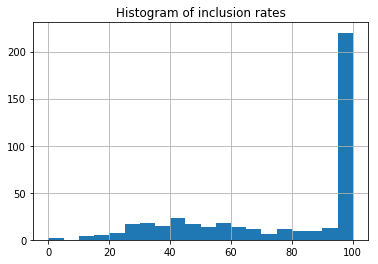

In [17]:
plt.hist(inclusion_rates , bins=20)
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()

In [18]:
# mean inclusion rate
np.mean(np.array(inclusion_rates))

76.10880459770115

In [19]:
# median inclusion rate
np.median(np.array(inclusion_rates)) 
# 50 % of the actual paragraphs have an inclusion rate of at least

95.83

In [20]:
# 70% of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 30)

56.83599999999999

In [21]:
# 75 % of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 25)

50.0

In [22]:
# 90% of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 10)

32.454

In [23]:
# examine the extra_bagage_rate (like false positive rate, sorta)
print("----------------")
print('mean bagage rate: ', np.mean(np.array(extra_baggage_rate)))
print('median bagage rate: ', np.median(np.array(extra_baggage_rate)))
print("")

----------------
mean bagage rate:  26.247977011494253
median bagage rate:  25.0



In [24]:
np.percentile(extra_baggage_rate, 70)
# only 30% of my nominees have a bagage rate of at least?

33.29199999999998

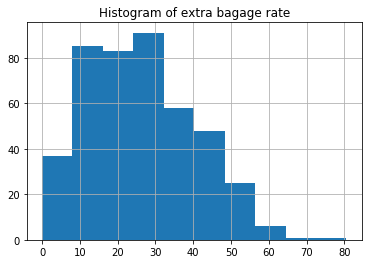

In [25]:
plt.hist(extra_baggage_rate)
plt.title('Histogram of extra bagage rate')
plt.grid()
plt.show()

In [26]:
# compare the lengths of the actual paratokens to the nominated paratokens

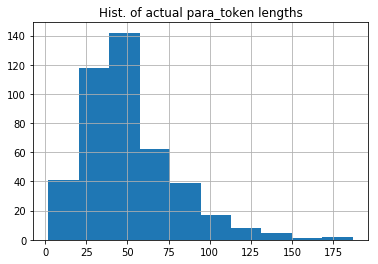

In [27]:
plt.hist(actual_paratokens_lengths)
plt.title('Hist. of actual para_token lengths')
plt.grid()
plt.show()

In [28]:
print('mean ', np.mean(np.array(actual_paratokens_lengths)))
print('median', np.median(np.array(actual_paratokens_lengths)))
print('range', np.max(np.array(actual_paratokens_lengths)) - np.min(np.array(actual_paratokens_lengths)))

mean  51.11724137931034
median 46.0
range 185


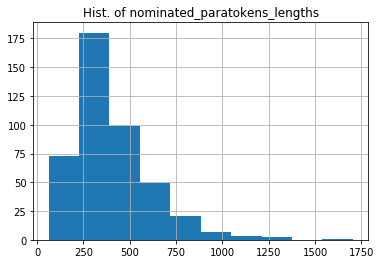

In [29]:
# now lets look at the nominated paratokens lengths
plt.hist(nominated_paratokens_lengths)
plt.title('Hist. of nominated_paratokens_lengths')
plt.grid()
plt.show()

In [30]:
print('mean ', np.mean(np.array(nominated_paratokens_lengths)))
print('median', np.median(np.array(nominated_paratokens_lengths)))
print('range', np.max(np.array(nominated_paratokens_lengths)) - np.min(np.array(nominated_paratokens_lengths)))

mean  406.19310344827585
median 355.0
range 1642


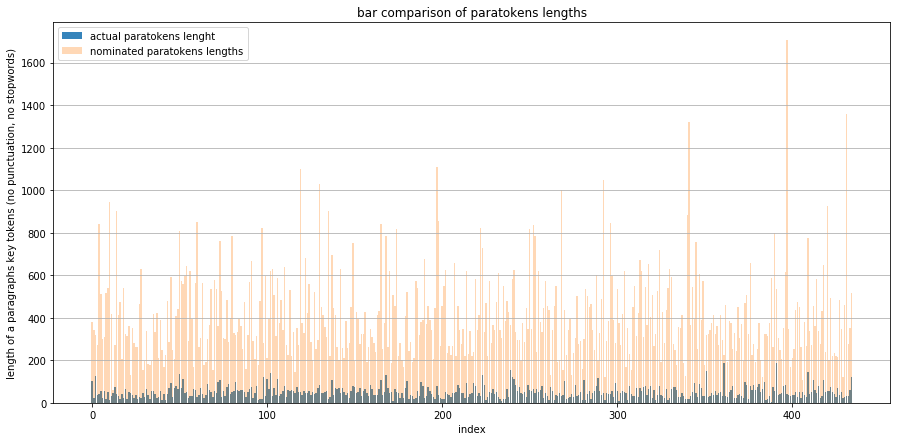

In [31]:
plt.figure(figsize = (15,7))
plt.bar(height = actual_paratokens_lengths, alpha = 0.9,
        x = range(len(actual_paratokens_lengths)))
plt.bar(height = nominated_paratokens_lengths, alpha = 0.3,
       x = range(len(nominated_paratokens_lengths)))
plt.title('bar comparison of paratokens lengths')
plt.legend(['actual paratokens lenght', 'nominated paratokens lengths'])
plt.xlabel('index')
plt.ylabel('length of a paragraphs key tokens (no punctuation, no stopwords)')
plt.grid(axis = 'y')
plt.show()

## do it again for only the top 7 key tokens

In [32]:
#predict

In [33]:
predicted_paragraph_df['pred_paragraph_text_7'] = ['nope' for row in predicted_paragraph_df.index]# initialize the pred_paragraph_text column



/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
### limit ourselves to the 7 most common tokens
    # although this can be modulated if necessary
key_tokens = pd.DataFrame(Counter(no_stops).most_common(7))
key_tokens.columns = ['key_tok', 'kt_count']

In [35]:
# initialize some score keeping lists
total_inclusion = []
inclusion_rates = [] # analogous to true positive rate
extra_baggage_rate = [] # analogous to false positive rate, (sorta, cause the actual paragraph data is not to be treated as an absolute standard).
actual_paratokens_lengths = []
nominated_paratokens_lengths = []
filings_not_in_df = [] # track which, if any, filings were not found in the df
no_tokhits_filings = [] # track which filings I failed to find hits for, if any

t0 = datetime.datetime.now()

for filing in training_filings_list:
#for filing in vert_training_subset_filings_list:
    ti = datetime.datetime.now()
    #print('processing next filing at ', ti)
    
    
### this could be all be packed into a function if nec.
###
    # read in the filing's html
    with open(filing) as file:
        file_html = file.read()
    
    # parse the html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ##################------- Predict Paragraphs ------##############################################
    #define candidate paragraphs by clustering of overlapping token-hit-margins
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraphs and a hit tracker
    candidate_paragraphs = []
    hit = 0
    #
    # work through the hits until I exhaust the list
    while hit < len(flater_list_of_tokhits) - 1:
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
    #     
    #    # loop from the hit + 1 (cause we used the former hit to initialize the bounds)
        for i in range(hit + 1, len(flater_list_of_tokhits)):
    #        # if the next token's start is within the current paragraph's bounds and it isnt the last hit
            if (leftbound < flater_list_of_tokhits[i][1] < rightbound) and (i != len(flater_list_of_tokhits) - 1):
    #            # expand the right bound with respect to next token's end
                rightbound = flater_list_of_tokhits[i][2] + margin
    #             
    #        # if next token is outside the bounds of current paragraph or we are at the penultimate hit
            else:
    #            # if right bound is out of htmls range, then adjust it to the end of the html
                if rightbound > len(string_filing):
                    rightbound = len(string_filing)
    #            # define current paragraph
                par = string_filing[leftbound:rightbound] ########### (if the code needs to be made more efficient I could store the paragraph start and end indices instead of storing the strings)
    #            # store the paragraph in a list of candidates
                candidate_paragraphs.append(par)
    #            # note which hit we need to start on for the next iteration of the while loop
                hit = i
    #            # now that we've found the outer bounds of the current paragraph we can interrupt the for loop
                break #this only interrupts the nearest parent loop 
    # this is just a repetition of the above routine to handle the last hit. There is probably a better way to handle this but we can enhance that later
    if hit == len(flater_list_of_tokhits)-1:
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
        if rightbound > len(string_filing):
            rightbound = len(string_filing)
        par = string_filing[leftbound:rightbound]
        candidate_paragraphs.append(par)
    #--------------------------------------------------------------------------------------#
    
    #################--------- Validate Predictions ----------------------##################
    # Future Enhancements:
    # - I could make the loop "reactive" so that if the validation score of the first
    #      nominated paragraph is low it con test the validation score of the second 
    #      nominee
    #
    # --------------- temporarily store the candidate paragraphs in a df ------------------
    candidate_df = pd.DataFrame(candidate_paragraphs)
    candidate_df.columns = ['cand_par']
    candidate_df['len'] = [len(par) for par in candidate_df.cand_par]
    # --------------- rank the candidate paragraphs by basic length (longer paragraphs correspond to denser clusters)
    candidate_df.sort_values(by = 'len', ascending = False, inplace = True)
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- filter candidates down to those with 'repurchase' in them
    candidate_df = candidate_df[['repurchase' in par for par in candidate_df.cand_par]]
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- nominee(s) will be the top 1 - 3 in the filterd df
    if len(candidate_df.cand_par) != 0:
        nominated = candidate_df.cand_par[0]
    elif len(candidate_df.cand_par) == 0:
        # if I failed define a single candidate paragraph
        print('failed to define a single candidate paragraph for filing', filing)
        print('defaulted to using the nominated paragraph from the last filing')
        no_tokhits_filings.append(filing)
    # clean up the nominee for validation
    nom_validatable = re.sub(r'\n+', ' ', nominated) # remove new lines
    nom_validatable = re.sub(r'\s+', ' ', nom_validatable) # trim all repeated whitespace down to one
    # filter out stop words and non-alphanumeric content
    # apply the same filtering process to nom_validatable
    nominated_tokens = [wt for wt in word_tokenize(nom_validatable) if (wt.isalnum() and wt not in stopwords.words('english'))] # yes there is redundancy but that can be optimized later
    #
    
    # --------------- isolate csv's actual paragraph for valiation
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    # use it to filter down to the csv rows with that an
    #
    # ⚠️ notice that for expediencey I am only using the first row with a given accession number. (there could be up to 7 rows with the same accession number in the actual csv). The reason for this misalignment is because the primary purpose of this pipeline is to identify paragraphs with target information, it's purpose is not to define up to 7 paragraphs for each filing number.
    # 🤔 to enhance this pipeline to work with the original csv I could pick my actual_paragraph to be one with a specific dkfn
    #relev_bool_index = [ac_n == an and dkfn in relevant_dkfns for ac_n, dkfn in zip(vert_training_subset_df.accession_number, vert_training_subset_df.data_key_friendly_name)]
    if an not in share_rprchs_prgrph_df.accession_number.values:
        print(an, 'was not found in the filings data frame')
        filings_not_in_df.append(an)
        continue
    
    actual_paragraph = share_rprchs_prgrph_df[[ac_n == an and dkfn in relevant_dkfns for ac_n, dkfn in zip(share_rprchs_prgrph_df.accession_number, share_rprchs_prgrph_df.data_key_friendly_name)]].head(1).paragraph_text
    # some rows don't have my relevant dkfns and the above assignment creates an empty series
    # so to handle that just pick the first row at random, for now
    if len(actual_paragraph) == 0:
        print('accession number', an, 'did not have a relevant dkfn row in the data frame')
        actual_paragraph = share_rprchs_prgrph_df[share_rprchs_prgrph_df.accession_number == an].head(1).paragraph_text
    # extract the string from the resulting pandas series
    actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
    actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
    actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
    # filter out stop words, punctuation, and other non-alphanumeric stuff
    actual_tokens = [wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))] #yes there is probably some redundancy here but that can be refined later
    
    # moment of truth
    #---------------------------------------------------------    
    # calculate the inclusion rates
    counter = 0
    for wt in actual_tokens:
        if wt in nominated_tokens:
            counter += 1
    x = round(100*counter/len(actual_tokens),2)
    
    # calculate the extra_baggage_rates
    bag_counter = 0
    for wt in nominated_tokens:
        if wt in actual_tokens:
            bag_counter += 1
    z = round(100*bag_counter/len(nominated_tokens), 2)
    
    
    # keeping score
    # ---------------------------------------------------------
    total_inclusion.append(actual_paragraph in nom_validatable)
    inclusion_rates.append(x)
    extra_baggage_rate.append(z)
    actual_paratokens_lengths.append(len(actual_tokens))
    nominated_paratokens_lengths.append(len(nominated_tokens))
    #-------------------------------------------------------------------------------#
    
    ################--------- Write Predicted Paragraphs to Data-Frame ------------##############
    predicted_paragraph_df.pred_paragraph_text_7[predicted_paragraph_df.accession_number == an] = nominated
    #------------------------------------------------------------------------------------------#
    
    #tf = datetime.datetime.now()
    #print('processed filing', len(total_inclusion), 'at ', tf, '. Process took', tf - ti)
    #print("--------------------------")
    
tf = datetime.datetime.now()
print("")
print('entire cycle took ', tf - t0)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/pauloma

accession number 0000815556-18-000010 did not have a relevant dkfn row in the data frame
accession number 0000109380-18-000102 did not have a relevant dkfn row in the data frame
accession number 0001058090-18-000018 did not have a relevant dkfn row in the data frame
accession number 0001043277-18-000007 did not have a relevant dkfn row in the data frame
accession number 0001144204-18-020717 did not have a relevant dkfn row in the data frame
accession number 0001113169-18-000009 did not have a relevant dkfn row in the data frame
accession number 0000045012-18-000059 did not have a relevant dkfn row in the data frame
accession number 0000096223-18-000009 did not have a relevant dkfn row in the data frame
accession number 0000029905-18-000013 did not have a relevant dkfn row in the data frame
accession number 0001095073-18-000008 did not have a relevant dkfn row in the data frame
accession number 0000091419-17-000005 did not have a relevant dkfn row in the data frame
accession number 0001

In [36]:
# were there any filings I failed to find a single hit for?
print(len(no_tokhits_filings))

1


In [37]:
# were there any filings not found in the dataframe?
print(len(filings_not_in_df))

0


In [38]:
#### examine total_inclusion results (though this is a rather naive metric)

In [39]:
#len(total)
print(len(total_inclusion), 'total filings processed')
print(np.array(total_inclusion).sum(), 'number of paragraphs 100% included')
print(round(100*np.array(total_inclusion).sum()/len(total_inclusion), 2), '% total inclusion')
print("")

435 total filings processed
183 number of paragraphs 100% included
42.07 % total inclusion



It's interesting that when I used 15 (instead of 30) key tokens to define the paragraphs I somehow ended up with 12 more totally included paragraphs. 😐 
- How is this possible?
    - perhaps, my nominated paragraphs are different. They aren't just shorter. 
        - Before I was nominating the longest paragraph, but if I had a run on chain of false positive token hits then that paragraph would get nominated and thus the total inclusion would suffer. 

In [40]:
# examine the inclusion rates (analogous to true positive rate)

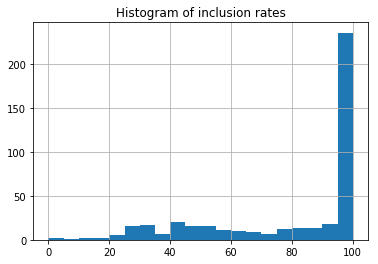

In [41]:
plt.hist(inclusion_rates , bins=20)
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()

In [42]:
# mean inclusion rate
np.mean(np.array(inclusion_rates))

79.62639080459769

In [43]:
# median inclusion rate
np.median(np.array(inclusion_rates)) 
# 50 % of the actual paragraphs have an inclusion rate of at least

98.08

In [44]:
# 70% of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 30)

66.82399999999998

In [45]:
# 75 % of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 25)

55.735

In [46]:
# 90% of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 10)

34.540000000000006

In [47]:
# examine the extra_bagage_rate (like false positive rate, sorta)
print("----------------")
print('mean bagage rate: ', np.mean(np.array(extra_baggage_rate)))
print('median bagage rate: ', np.median(np.array(extra_baggage_rate)))
print("")

----------------
mean bagage rate:  32.06170114942529
median bagage rate:  30.9



In [48]:
np.percentile(extra_baggage_rate, 70)
# only 30% of my nominees have a bagage rate of at least?

40.38999999999999

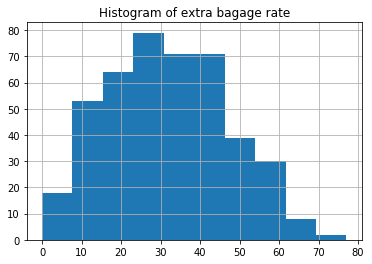

In [49]:
plt.hist(extra_baggage_rate)
plt.title('Histogram of extra bagage rate')
plt.grid()
plt.show()

In [50]:
# compare the lengths of the actual paratokens to the nominated paratokens

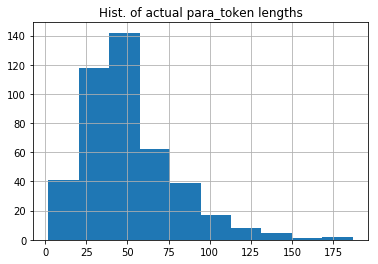

In [51]:
plt.hist(actual_paratokens_lengths)
plt.title('Hist. of actual para_token lengths')
plt.grid()
plt.show()

In [52]:
print('mean ', np.mean(np.array(actual_paratokens_lengths)))
print('median', np.median(np.array(actual_paratokens_lengths)))
print('range', np.max(np.array(actual_paratokens_lengths)) - np.min(np.array(actual_paratokens_lengths)))

mean  51.11724137931034
median 46.0
range 185


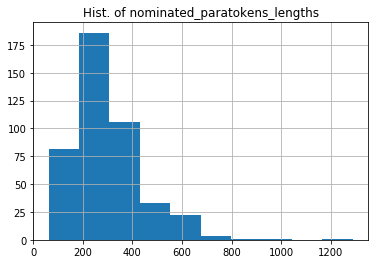

In [53]:
# now lets look at the nominated paratokens lengths
plt.hist(nominated_paratokens_lengths)
plt.title('Hist. of nominated_paratokens_lengths')
plt.grid()
plt.show()

In [54]:
print('mean ', np.mean(np.array(nominated_paratokens_lengths)))
print('median', np.median(np.array(nominated_paratokens_lengths)))
print('range', np.max(np.array(nominated_paratokens_lengths)) - np.min(np.array(nominated_paratokens_lengths)))

mean  298.7080459770115
median 266.0
range 1227


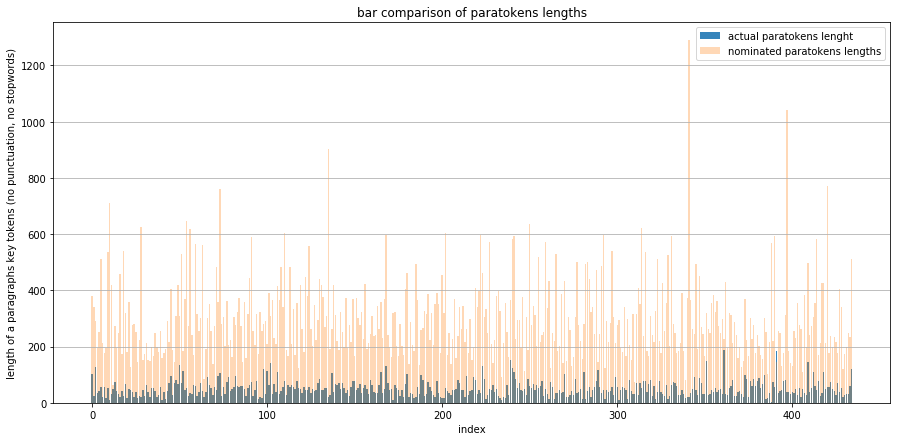

In [55]:
plt.figure(figsize = (15,7))
plt.bar(height = actual_paratokens_lengths, alpha = 0.9,
        x = range(len(actual_paratokens_lengths)))
plt.bar(height = nominated_paratokens_lengths, alpha = 0.3,
       x = range(len(nominated_paratokens_lengths)))
plt.title('bar comparison of paratokens lengths')
plt.legend(['actual paratokens lenght', 'nominated paratokens lengths'])
plt.xlabel('index')
plt.ylabel('length of a paragraphs key tokens (no punctuation, no stopwords)')
plt.grid(axis = 'y')
plt.show()

# eda on predicted paragraphs

In [56]:
predicted_paragraph_df

,ticker,accession_number,pred_paragraph_text,pred_paragraph_text_7
0,A,0001090872-17-000018,e chemical and energy markets.\n\nnet income f...,rtized related to the interest rate swap agree...
1,AAL,0000006201-18-000009,n recognition of the 2017 tax act.\n\n\n\n\n\n...,n recognition of the 2017 tax act.\n\n\n\n\n\n...
2,AAP,0001158449-18-000039,151.72\n\n\n\n\n\n$\n\n\n99.13\n\n\n\n\n\n \n\...,"\n\nwarranty reserves, beginning of period\n\n..."
3,AAPL,0000320193-17-000070,s business operations are subject\nto interrup...,ember 2016 asr\n\n\nfebruary 2017\n\n\n \n\n\n...
4,ABBV,0001551152-18-000014,hat generally vest in one-third increments ove...,hat generally vest in one-third increments ove...
5,ABC,0001140859-17-000047,ing illustrates the components of accumulated ...,"illion of 4.875% senior notes due november 15,..."
6,ABT,0001047469-18-000856,"\nin march 2015, abbott issued $2.5 billion of...",", 2022; and $1.0 billion of\n2.95% senior note..."
7,ACN,0001467373-17-000430,"our irish parent,\nprincipally dividend distr...","our irish parent,\nprincipally dividend distr..."
8,ADBE,0000796343-18-000015,elated to each component of other\ncomprehensi...,"\n\n\n \n\n\n24\n\n\n\n\n\n \n\n\n(3,378\n\n\n..."
9,ADI,0000006281-17-000144,"/awards granted\n\n\n4,809\n\n\n\n\n\n \n\n\n\...","tions lapsed\n\n\n(1,580\n\n\n)\n\n\n \n\n\n\n..."


## do it again for only the top 3 key tokens

In [57]:
#predict

In [58]:
predicted_paragraph_df['pred_paragraph_text_3'] = ['nope' for row in predicted_paragraph_df.index]# initialize the pred_paragraph_text column



/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
### limit ourselves to the 7 most common tokens
    # although this can be modulated if necessary
key_tokens = pd.DataFrame(Counter(no_stops).most_common(7))
key_tokens.columns = ['key_tok', 'kt_count']

In [60]:
# initialize some score keeping lists
total_inclusion = []
inclusion_rates = [] # analogous to true positive rate
extra_baggage_rate = [] # analogous to false positive rate, (sorta, cause the actual paragraph data is not to be treated as an absolute standard).
actual_paratokens_lengths = []
nominated_paratokens_lengths = []
filings_not_in_df = [] # track which, if any, filings were not found in the df
no_tokhits_filings = [] # track which filings I failed to find hits for, if any

t0 = datetime.datetime.now()

for filing in training_filings_list:
#for filing in vert_training_subset_filings_list:
    ti = datetime.datetime.now()
    #print('processing next filing at ', ti)
    
    
### this could be all be packed into a function if nec.
###
    # read in the filing's html
    with open(filing) as file:
        file_html = file.read()
    
    # parse the html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ##################------- Predict Paragraphs ------##############################################
    #define candidate paragraphs by clustering of overlapping token-hit-margins
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraphs and a hit tracker
    candidate_paragraphs = []
    hit = 0
    #
    # work through the hits until I exhaust the list
    while hit < len(flater_list_of_tokhits) - 1:
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
    #     
    #    # loop from the hit + 1 (cause we used the former hit to initialize the bounds)
        for i in range(hit + 1, len(flater_list_of_tokhits)):
    #        # if the next token's start is within the current paragraph's bounds and it isnt the last hit
            if (leftbound < flater_list_of_tokhits[i][1] < rightbound) and (i != len(flater_list_of_tokhits) - 1):
    #            # expand the right bound with respect to next token's end
                rightbound = flater_list_of_tokhits[i][2] + margin
    #             
    #        # if next token is outside the bounds of current paragraph or we are at the penultimate hit
            else:
    #            # if right bound is out of htmls range, then adjust it to the end of the html
                if rightbound > len(string_filing):
                    rightbound = len(string_filing)
    #            # define current paragraph
                par = string_filing[leftbound:rightbound] ########### (if the code needs to be made more efficient I could store the paragraph start and end indices instead of storing the strings)
    #            # store the paragraph in a list of candidates
                candidate_paragraphs.append(par)
    #            # note which hit we need to start on for the next iteration of the while loop
                hit = i
    #            # now that we've found the outer bounds of the current paragraph we can interrupt the for loop
                break #this only interrupts the nearest parent loop 
    # this is just a repetition of the above routine to handle the last hit. There is probably a better way to handle this but we can enhance that later
    if hit == len(flater_list_of_tokhits)-1:
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
        if rightbound > len(string_filing):
            rightbound = len(string_filing)
        par = string_filing[leftbound:rightbound]
        candidate_paragraphs.append(par)
    #--------------------------------------------------------------------------------------#
    
    #################--------- Validate Predictions ----------------------##################
    # Future Enhancements:
    # - I could make the loop "reactive" so that if the validation score of the first
    #      nominated paragraph is low it con test the validation score of the second 
    #      nominee
    #
    # --------------- temporarily store the candidate paragraphs in a df ------------------
    candidate_df = pd.DataFrame(candidate_paragraphs)
    candidate_df.columns = ['cand_par']
    candidate_df['len'] = [len(par) for par in candidate_df.cand_par]
    # --------------- rank the candidate paragraphs by basic length (longer paragraphs correspond to denser clusters)
    candidate_df.sort_values(by = 'len', ascending = False, inplace = True)
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- filter candidates down to those with 'repurchase' in them
    candidate_df = candidate_df[['repurchase' in par for par in candidate_df.cand_par]]
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- nominee(s) will be the top 1 - 3 in the filterd df
    if len(candidate_df.cand_par) != 0:
        nominated = candidate_df.cand_par[0]
    elif len(candidate_df.cand_par) == 0:
        # if I failed define a single candidate paragraph
        print('failed to define a single candidate paragraph for filing', filing)
        print('defaulted to using the nominated paragraph from the last filing')
        no_tokhits_filings.append(filing)
    # clean up the nominee for validation
    nom_validatable = re.sub(r'\n+', ' ', nominated) # remove new lines
    nom_validatable = re.sub(r'\s+', ' ', nom_validatable) # trim all repeated whitespace down to one
    # filter out stop words and non-alphanumeric content
    # apply the same filtering process to nom_validatable
    nominated_tokens = [wt for wt in word_tokenize(nom_validatable) if (wt.isalnum() and wt not in stopwords.words('english'))] # yes there is redundancy but that can be optimized later
    #
    
    # --------------- isolate csv's actual paragraph for valiation
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    # use it to filter down to the csv rows with that an
    #
    # ⚠️ notice that for expediencey I am only using the first row with a given accession number. (there could be up to 7 rows with the same accession number in the actual csv). The reason for this misalignment is because the primary purpose of this pipeline is to identify paragraphs with target information, it's purpose is not to define up to 7 paragraphs for each filing number.
    # 🤔 to enhance this pipeline to work with the original csv I could pick my actual_paragraph to be one with a specific dkfn
    #relev_bool_index = [ac_n == an and dkfn in relevant_dkfns for ac_n, dkfn in zip(vert_training_subset_df.accession_number, vert_training_subset_df.data_key_friendly_name)]
    if an not in share_rprchs_prgrph_df.accession_number.values:
        print(an, 'was not found in the filings data frame')
        filings_not_in_df.append(an)
        continue
    
    actual_paragraph = share_rprchs_prgrph_df[[ac_n == an and dkfn in relevant_dkfns for ac_n, dkfn in zip(share_rprchs_prgrph_df.accession_number, share_rprchs_prgrph_df.data_key_friendly_name)]].head(1).paragraph_text
    # some rows don't have my relevant dkfns and the above assignment creates an empty series
    # so to handle that just pick the first row at random, for now
    if len(actual_paragraph) == 0:
        print('accession number', an, 'did not have a relevant dkfn row in the data frame')
        actual_paragraph = share_rprchs_prgrph_df[share_rprchs_prgrph_df.accession_number == an].head(1).paragraph_text
    # extract the string from the resulting pandas series
    actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
    actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
    actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
    # filter out stop words, punctuation, and other non-alphanumeric stuff
    actual_tokens = [wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))] #yes there is probably some redundancy here but that can be refined later
    
    # moment of truth
    #---------------------------------------------------------    
    # calculate the inclusion rates
    counter = 0
    for wt in actual_tokens:
        if wt in nominated_tokens:
            counter += 1
    x = round(100*counter/len(actual_tokens),2)
    
    # calculate the extra_baggage_rates
    bag_counter = 0
    for wt in nominated_tokens:
        if wt in actual_tokens:
            bag_counter += 1
    z = round(100*bag_counter/len(nominated_tokens), 2)
    
    
    # keeping score
    # ---------------------------------------------------------
    total_inclusion.append(actual_paragraph in nom_validatable)
    inclusion_rates.append(x)
    extra_baggage_rate.append(z)
    actual_paratokens_lengths.append(len(actual_tokens))
    nominated_paratokens_lengths.append(len(nominated_tokens))
    #-------------------------------------------------------------------------------#
    
    ################--------- Write Predicted Paragraphs to Data-Frame ------------##############
    predicted_paragraph_df.pred_paragraph_text_3[predicted_paragraph_df.accession_number == an] = nominated
    #------------------------------------------------------------------------------------------#
    
    #tf = datetime.datetime.now()
    #print('processed filing', len(total_inclusion), 'at ', tf, '. Process took', tf - ti)
    #print("--------------------------")
    
tf = datetime.datetime.now()
print("")
print('entire cycle took ', tf - t0)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/pauloma

accession number 0000815556-18-000010 did not have a relevant dkfn row in the data frame
accession number 0000109380-18-000102 did not have a relevant dkfn row in the data frame
accession number 0001058090-18-000018 did not have a relevant dkfn row in the data frame
accession number 0001043277-18-000007 did not have a relevant dkfn row in the data frame
accession number 0001144204-18-020717 did not have a relevant dkfn row in the data frame
accession number 0001113169-18-000009 did not have a relevant dkfn row in the data frame
accession number 0000045012-18-000059 did not have a relevant dkfn row in the data frame
accession number 0000096223-18-000009 did not have a relevant dkfn row in the data frame
accession number 0000029905-18-000013 did not have a relevant dkfn row in the data frame
accession number 0001095073-18-000008 did not have a relevant dkfn row in the data frame
accession number 0000091419-17-000005 did not have a relevant dkfn row in the data frame
accession number 0001

In [61]:
# were there any filings I failed to find a single hit for?
print(len(no_tokhits_filings))

1


In [62]:
# were there any filings not found in the dataframe?
print(len(filings_not_in_df))

0


In [63]:
#### examine total_inclusion results (though this is a rather naive metric)

In [64]:
#len(total)
print(len(total_inclusion), 'total filings processed')
print(np.array(total_inclusion).sum(), 'number of paragraphs 100% included')
print(round(100*np.array(total_inclusion).sum()/len(total_inclusion), 2), '% total inclusion')
print("")

435 total filings processed
183 number of paragraphs 100% included
42.07 % total inclusion



reducing the hits to the top 3 made no difference from the top 7

In [65]:
# examine the inclusion rates (analogous to true positive rate)

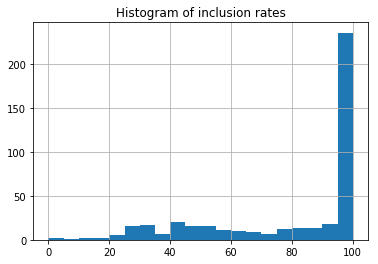

In [66]:
plt.hist(inclusion_rates , bins=20)
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()

In [67]:
# mean inclusion rate
np.mean(np.array(inclusion_rates))

79.62639080459769

In [68]:
# median inclusion rate
np.median(np.array(inclusion_rates)) 
# 50 % of the actual paragraphs have an inclusion rate of at least

98.08

In [69]:
# 70% of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 30)

66.82399999999998

In [70]:
# 75 % of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 25)

55.735

In [71]:
# 90% of the actual paragraphs have an inclusion rate of at least
np.percentile(inclusion_rates, 10)

34.540000000000006

No difference from top 7

In [72]:
# examine the extra_bagage_rate (like false positive rate, sorta)
print("----------------")
print('mean bagage rate: ', np.mean(np.array(extra_baggage_rate)))
print('median bagage rate: ', np.median(np.array(extra_baggage_rate)))
print("")

----------------
mean bagage rate:  32.06170114942529
median bagage rate:  30.9



In [73]:
np.percentile(extra_baggage_rate, 70)
# only 30% of my nominees have a bagage rate of at least?

40.38999999999999

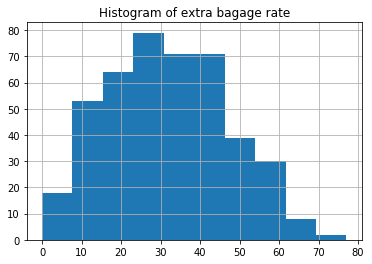

In [74]:
plt.hist(extra_baggage_rate)
plt.title('Histogram of extra bagage rate')
plt.grid()
plt.show()

In [75]:
# compare the lengths of the actual paratokens to the nominated paratokens

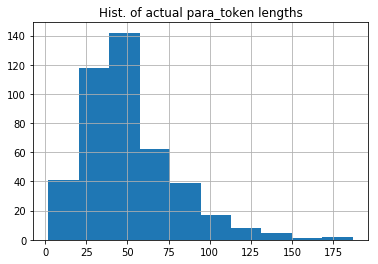

In [76]:
plt.hist(actual_paratokens_lengths)
plt.title('Hist. of actual para_token lengths')
plt.grid()
plt.show()

In [77]:
print('mean ', np.mean(np.array(actual_paratokens_lengths)))
print('median', np.median(np.array(actual_paratokens_lengths)))
print('range', np.max(np.array(actual_paratokens_lengths)) - np.min(np.array(actual_paratokens_lengths)))

mean  51.11724137931034
median 46.0
range 185


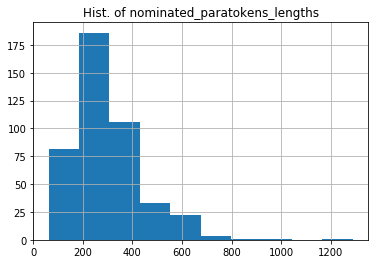

In [78]:
# now lets look at the nominated paratokens lengths
plt.hist(nominated_paratokens_lengths)
plt.title('Hist. of nominated_paratokens_lengths')
plt.grid()
plt.show()

In [79]:
print('mean ', np.mean(np.array(nominated_paratokens_lengths)))
print('median', np.median(np.array(nominated_paratokens_lengths)))
print('range', np.max(np.array(nominated_paratokens_lengths)) - np.min(np.array(nominated_paratokens_lengths)))

mean  298.7080459770115
median 266.0
range 1227


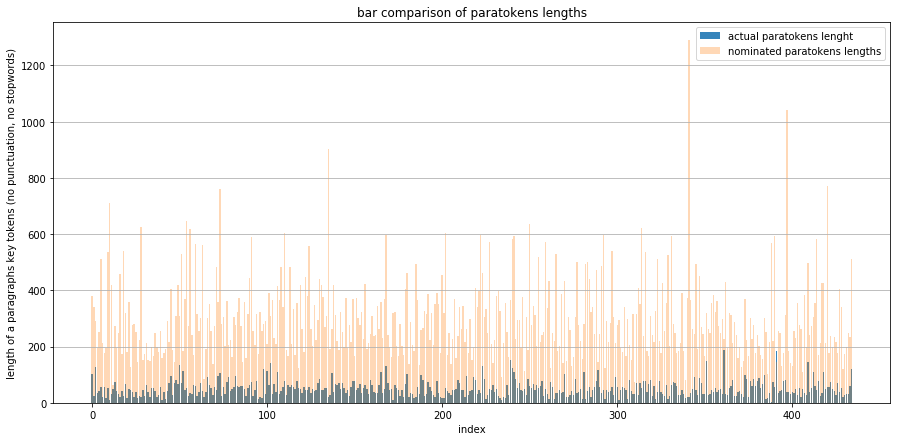

In [80]:
plt.figure(figsize = (15,7))
plt.bar(height = actual_paratokens_lengths, alpha = 0.9,
        x = range(len(actual_paratokens_lengths)))
plt.bar(height = nominated_paratokens_lengths, alpha = 0.3,
       x = range(len(nominated_paratokens_lengths)))
plt.title('bar comparison of paratokens lengths')
plt.legend(['actual paratokens lenght', 'nominated paratokens lengths'])
plt.xlabel('index')
plt.ylabel('length of a paragraphs key tokens (no punctuation, no stopwords)')
plt.grid(axis = 'y')
plt.show()

# take a peak at the predicted dataframe

In [83]:
predicted_paragraph_df.head()

,ticker,accession_number,pred_paragraph_text,pred_paragraph_text_7,pred_paragraph_text_3
0,A,0001090872-17-000018,e chemical and energy markets.\n\nnet income f...,rtized related to the interest rate swap agree...,rtized related to the interest rate swap agree...
1,AAL,0000006201-18-000009,n recognition of the 2017 tax act.\n\n\n\n\n\n...,n recognition of the 2017 tax act.\n\n\n\n\n\n...,n recognition of the 2017 tax act.\n\n\n\n\n\n...
2,AAP,0001158449-18-000039,151.72\n\n\n\n\n\n$\n\n\n99.13\n\n\n\n\n\n \n\...,"\n\nwarranty reserves, beginning of period\n\n...","\n\nwarranty reserves, beginning of period\n\n..."
3,AAPL,0000320193-17-000070,s business operations are subject\nto interrup...,ember 2016 asr\n\n\nfebruary 2017\n\n\n \n\n\n...,ember 2016 asr\n\n\nfebruary 2017\n\n\n \n\n\n...
4,ABBV,0001551152-18-000014,hat generally vest in one-third increments ove...,hat generally vest in one-third increments ove...,hat generally vest in one-third increments ove...


In [89]:
predicted_paragraph_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 5 columns):
ticker                   435 non-null object
accession_number         435 non-null object
pred_paragraph_text      435 non-null object
pred_paragraph_text_7    435 non-null object
pred_paragraph_text_3    435 non-null object
dtypes: object(5)
memory usage: 17.1+ KB


#### compare predictions 15 to predictions 7 

In [88]:
# number of pred15s that are equal to pred7s
np.sum([predicted_paragraph_df.pred_paragraph_text == predicted_paragraph_df.pred_paragraph_text_7])

94

In [98]:
100*np.sum([predicted_paragraph_df.pred_paragraph_text == predicted_paragraph_df.pred_paragraph_text_7])/len(predicted_paragraph_df.pred_paragraph_text)

21.60919540229885

Note: 94/434 = 21.61% are the same

In [91]:
# total inclusion of pred7 in pred 15
np.sum([p7 in p15 for p7, p15 in zip(predicted_paragraph_df.pred_paragraph_text_7, predicted_paragraph_df.pred_paragraph_text)])

291

In [97]:
# total inclusion of pred7 in pred 15
100*np.sum([p7 in p15 for p7, p15 in zip(predicted_paragraph_df.pred_paragraph_text_7, predicted_paragraph_df.pred_paragraph_text)])/predicted_paragraph_df.shape[0]

66.89655172413794

That's interresting only 66.90% of my prediction7s are inside the prediction15s. That means about 30% of my pred7s are distinct from my pred 15s. And that only resulted in a 2.5% increase in todal inclusion (12 extra total inclusions.)

In [100]:
'lf wor' in 'half word'

True

#### compare predictions 7 to predictions 3

In [101]:
# number of pred3s that are equal to pred7s
np.sum([predicted_paragraph_df.pred_paragraph_text_3 == predicted_paragraph_df.pred_paragraph_text_7])

435

In [102]:
100*np.sum([predicted_paragraph_df.pred_paragraph_text_3 == predicted_paragraph_df.pred_paragraph_text_7])/len(predicted_paragraph_df.pred_paragraph_text)

100.0

Note: pred 3 generated the same paragraphs as pred 7.
So I can drop one of them

**Future Enhancements: (Improving/Shortening Nominated/Predicted Paragraphs)**

🤔 I can probably train a ML on the original csv's paragraph column, and use it to further distill my predicted paragraphs. 
- I guess that would look like:
    - sentence tokenizing the the paragraphs (both of them)
        - labeling the training sent_tokens as 'relevant'
        - fit and train on them
        - classify the sentences in sent_tokens in my predicted paragraphs as (ir)relevant
        - return only the ones the model predicts to be relevant

# Predicting Sentence Classification
## Build word count vectors with skikit-learn
### Count Vectorizer with Python

In [113]:
share_rprchs_prgrph_df.data_key_friendly_name.value_counts()

Share Repurchase Authorization Date    401
Share Repurchase Authorization         369
Amount Spent on Share Repurchases      329
Share Repurchase Count                 286
Share Repurchase Intention             227
Unknown Share Repurchase Data          122
Share Repurchase Utilization            47
Name: data_key_friendly_name, dtype: int64

In [130]:
vert_training_subset_df[['data_key_friendly_name', 'text']].head()

,data_key_friendly_name,text
0,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...
1,Share Repurchase Intention,remaining authorization to repurchase up to
2,Share Repurchase Authorization,share repurchase programs aggregating
3,Share Repurchase Intention,remained unused under a repurchase program
4,Share Repurchase Intention,remaining under its stock repurchase program a...


In [133]:
share_rprchs_prgrph_df.shape

(1781, 8)

## Is the "training" data they gave us, of sufficient quality to bother fitting a sentence classification model to it?
Assuming they gave us quality data, then:
- each row's 'text' column should contain the data named in the dkfn
    - if it's not immediately apparent from the text column it should, at the very least, be apparent from the paragraph colum

⚠️ if the data is too noisy, then training and fitting a model to the noise will be counterproductive, 
- if the odel becomes 80% effective, then it will be 80% effective at predicting the signal, but also 80% effective at predicting the particular noise in the training data (just compounding failure).

In [135]:
for dkfn in relevant_dkfns:
    print("[========== DKFN: ", dkfn, '=================]')
    for i in range(len(vert_training_subset_df[vert_training_subset_df.data_key_friendly_name == dkfn].text[0:15])):
        print('   [-', vert_training_subset_df.text[i], '-]')

[========== DKFN:  Share Repurchase Authorization =================]
   [- The 2015 share repurchase program authorizes the purchase of up to -]
   [- remaining authorization to repurchase up to -]
   [- share repurchase programs aggregating -]
   [- remained unused under a repurchase program -]
   [- remaining under its stock repurchase program as of December 30, 2017 -]
   [- repurchase program -]
   [- share repurchase authorization -]
   [- utilized -]
   [- Total -]
   [- authorized -]
   [- repurchased -]
   [- authorized the repurchase -]
   [- repurchased -]
   [- repurchased -]
   [- repurchase -]
[========== DKFN:  Share Repurchase Utilization =================]
   [- The 2015 share repurchase program authorizes the purchase of up to -]
   [- remaining authorization to repurchase up to -]
   [- share repurchase programs aggregating -]
   [- remained unused under a repurchase program -]
   [- remaining under its stock repurchase program as of December 30, 2017 -]
   [- repurch

😒 
The quality of this data seems dubious.
- total
- authorized
- utilized

I guess I should curate it "manually/personally"

**Helper pseudo-routine to accelerate manual classification:**
- for each of my 'relevant_dkfns'
    - look at the text
        - if it hasn't already been labeled as relevant (with respect to its dknf)
        - (if a given text has been marked as irrelevant with respect to it's corresponding paragraph that need not mean all it's other instances are irreleveant to their corresponding paragraphs.)
    - is it clearly relevant?
        - if not, then pull up it's paragraph
            - does the paragraph corroborate it's relevance?
                - if not, then mark it as 'irrelevant'
                - scrutinize the paragraph and classify it as (ir)relevant

In [175]:
vert_training_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 9 columns):
ticker                    415 non-null object
accession_number          415 non-null object
data_key_friendly_name    415 non-null object
text                      415 non-null object
data_value                415 non-null int64
reported_data_value       415 non-null float64
reported_units            415 non-null object
paragraph_text            415 non-null object
relevant4training         0 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 52.4+ KB


In [182]:
# initialize a classification column in the vertical subset
vert_training_subset_df['relevant4training'] = None
# initialize a personally curated column of relevant sentences
vert_training_subset_df['better_text'] = None

In [188]:
for dkfn in relevant_dkfns:
    # initiate a list to keep track of texts already classified as relevant
    relevant4dkfn = [] 
    # define a boolean index for this dkfn's subset
    dsubix = vert_training_subset_df.data_key_friendly_name == dkfn
    # note which subset we're entering
    print('Begin Classifiyng the >>>   ', dkfn, '   <<< subset of text cells.')
    print('='*100)
    # 
    for i in vert_training_subset_df[dsubix].index: # for each text cell in that subset
        if vert_training_subset_df.text[i] not in relevant4dkfn and vert_training_subset_df.relevant4training[i] == None: #if it hasn't already been marked as clearly relevant 
            print('- - '*25)
            print(vert_training_subset_df.text[i])
            print("^")
            relevance = input('Is the above text strictly and clearly relevant to '+dkfn+' [yes] or [no]')
            # hanle typos
            while relevance not in ['yes', 'no']:
                print('!!! Oops, need a yes or no input.')
                relevance = input('Is the above text strictly and clearly relevant to '+dkfn+'? [yes] or [no]')
            # if it is relevant append it and move on
            if relevance == 'yes':
                relevant4dkfn.append(vert_training_subset_df.text[i]) # not that we have already classified this
                vert_training_subset_df.relevant4training[i] = 1
                continue # continue to the next loop iteration
            
            # if not relevant look at paragraph
            if relevance == 'no':
                print('     ----- Take a look at the corresponding paragraph -----')
                print('.'*80)
                print(vert_training_subset_df.paragraph_text[i])
                relevance = input('Does the paragraph corroborate the strict relevance to '+dkfn+'? [yes] or [no]')
                print('.-.-.-.-.')
                # handle typos
                while relevance not in ['yes', 'no']:
                    print('!!! Oops, need a yes or no input.')
                    relevance = input('Is the above text value strictly and  relevant to '+dkfn+'? [yes] or [no]')
                if relevance == 'yes':
                    # we wont add it to the list of relevant texts in this case because maybe the relevance is parasitic on the paragraph, and so should not be generalized across different paragraphs
                    vert_training_subset_df.relevant4training[i] = 1
                    continue # continue to the next loop iteration
                if relevance == 'no':
                    vert_training_subset_df.relevant4training[i] = 0
                    # ask for a better text/sentence
                    better_alternative = 'no'
                    better_alternative = input('Do you have a better text value to add? [yes] [no]')
                    # handle typos
                    while better_alternative not in ['yes', 'no']:
                        print('!!! Oops, need a yes or no input.')
                        better_alternative = input('Do you have a better text value to add? [yes] [no]')
                    if better_alternative == 'yes':
                        vert_training_subset_df.better_text[i] = input('Type your selected text here: ')
                        # handle typos
                        good2go = 'no'
                        good2go = input('Good to go? [yes] or [no]')
                        while good2go not in ['yes', 'no']:
                            print('!!! Oops need a yes or no input')
                            good2go = input('Good to go? [yes], [no]')
                        if good2go == 'no':
                            vert_training_subset_df.better_text[i] = input('Type your selected text here: ')
                            # handle typos
                            good2go = 'no'
                            good2go = input('Good to go? [yes] or [no]')
                            while good2go not in ['yes', 'no']:
                                print('!!! Oops need a yes or no input')
                                good2go = input('Good to go? [yes], [no]')    
            print('- -'*33)

Begin Classifiyng the >>>    Share Repurchase Authorization    <<< subset of text cells.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
share repurchase program
^
Is the above text strictly and clearly relevant to Share Repurchase Authorization [yes] or [no]yes


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
our board of directors authorized an additional
^
Is the above text strictly and clearly relevant to Share Repurchase Authorization [yes] or [no]yes
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
the Company's Board of Directors authorized repurchase of up to
^
Is the above text strictly and clearly relevant to Share Repurchase Authorization [yes] or [no]yes
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
the Company announced that its Board of Directors authorized the repurchase of up to
^
Is the above text strictly and clearly relevant to Share Repurchase Authorization [yes] or [no]yes
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
the Board granted authority for a
^
Is the above text strictly and clearly relevant to Share Rep

KeyboardInterrupt: 

In [190]:
vert_training_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 10 columns):
ticker                    415 non-null object
accession_number          415 non-null object
data_key_friendly_name    415 non-null object
text                      415 non-null object
data_value                415 non-null int64
reported_data_value       415 non-null float64
reported_units            415 non-null object
paragraph_text            415 non-null object
relevant4training         62 non-null object
better_text               18 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 55.7+ KB


This is taking too long. Let's just assume that the data is good. 

How would I define a a sentence? They aren't single words, and they aren't Complete sentences either. 
- What determines the length of these fragments?
    - I'm not sure because the process that defined them is a black box
- Then I can take a probabilistic approach to their lengths. 
- Or I could repeat my paragraph defining strategy of density of hits
    - find the mean length of the texts
    - then scroll through the paragraph and score each selection
    - the one with the highest density of hits would be the one